In [7]:
import io
import random

import IPython
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.modules.loss import CrossEntropyLoss, _Loss
from torch.nn.modules.activation import GELU
import torchvision

from PIL import Image
from sklearn.manifold import TSNE

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(seed=SEED)
torch.manual_seed(seed=SEED)
torch.cuda.manual_seed_all(seed=SEED)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## T-SNE based visualiser

In [3]:
class EmbeddingVisualizer:
    def __init__(self) -> None:
        self.canvas, self.ax = plt.subplots(1, 1, figsize=(4, 4))  # type: tuple[Figure, Axes]
        self.embeddings: list[torch.Tensor] = []  # list of tensors (N x E)
        self.labels: list[torch.Tensor] = []  # list of tensors (N)

    def _convert2pil(self) -> Image.Image:
        buf = io.BytesIO()
        self.canvas.savefig(buf, format="png", transparent=False)
        plt.close(self.canvas)
        buf.seek(0)
        img = Image.open(buf).convert("RGB")
        buf.close()
        return img

    def store(self, embeddings: torch.Tensor, labels: torch.Tensor) -> None:
        if embeddings.size(0) != labels.size(0):
            raise RuntimeError(
                f"Irregular in #samples is detected."
                f" given `embeddings` has {embeddings.size(0)} samples"
                f" but `labels` has {labels.size(0)}."
            )
        if len(self.embeddings) > 0 and embeddings.size(1) != self.embeddings[-1].size(1):
            raise RuntimeError(
                f"Irregular in size of embeddings is detected."
                f" The size of given `embeddings` ({embeddings.size(1)})"
                f" do not equals to previous one ({self.embeddings[-1].size(1)})."
            )
        self.embeddings.append(embeddings)
        self.labels.append(labels)

    def visualize(self) -> Image.Image:
        embed = torch.cat(self.embeddings, dim=0).to(torch.device("cpu"))
        label = torch.cat(self.labels, dim=0).to(torch.device("cpu"))
        emb_reduced = TSNE(n_components=2, perplexity=10, random_state=0, init="pca", learning_rate="auto").fit_transform(embed)
        scatter_obj = self.ax.scatter(
            emb_reduced[:, 0],
            emb_reduced[:, 1],
            c=label,
            cmap="jet",
            alpha=0.5,
        )
        legend1 = self.ax.legend(*scatter_obj.legend_elements(), loc="upper left", title="Classes")
        self.ax.add_artist(legend1)
        return self._convert2pil()

In [4]:
train_data = torchvision.datasets.CIFAR10(root="./", train=True, download=True)
test_data = torchvision.datasets.CIFAR10(root="./", train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


Phase: train, Target: 6, Image size: (32, 32)


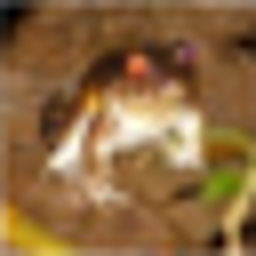

Phase: train, Target: 9, Image size: (32, 32)


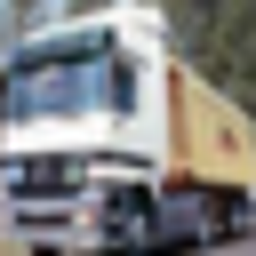

Phase: train, Target: 9, Image size: (32, 32)


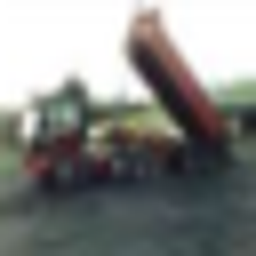

Phase: test, Target: 3, Image size: (32, 32)


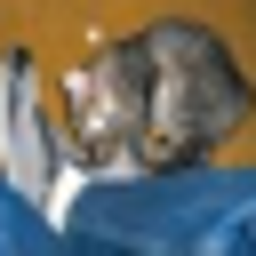

Phase: test, Target: 8, Image size: (32, 32)


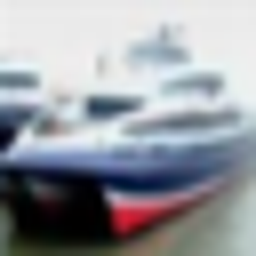

Phase: test, Target: 8, Image size: (32, 32)


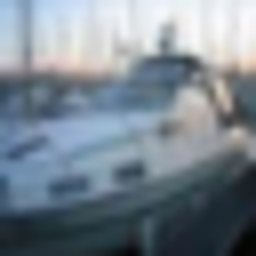

In [5]:
for phase, data in zip(["train", "test"], [train_data, test_data]):
    for i, (img, target) in enumerate(data, start=1):
        if i > 3:
            break
        print(f"Phase: {phase}, Target: {target}, Image size: {img.size}")
        IPython.display.display(img.resize((256, 256)))

In [6]:
def custom_collate_fn(batch):
    images, targets = map(list, zip(*batch))
    for i, img in enumerate(images):
        images[i] = torchvision.transforms.functional.pil_to_tensor(img.resize((224, 224)))
    images = torch.stack(images)
    targets = torch.tensor(targets).unsqueeze(1)
    return images, targets

In [8]:
# CNN model 
model = torchvision.models.efficientnet_b0(weights='DEFAULT').to(torch.float32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

compressor = nn.Sequential(
    nn.Linear(1000, 256),
    nn.GELU(),
    nn.Linear(256, 64),
).to(torch.float32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

label_encoder = nn.Sequential(
    nn.Linear(1, 256),
    nn.GELU(),
    nn.Linear(256, 64),
).to(torch.float32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
     

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [9]:
hparam_tau = torch.tensor([0.1]).to(torch.float32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
opt = torch.optim.AdamW(
    params = [
        *compressor.parameters(),
        *label_encoder.parameters(),
        hparam_tau
    ],
    lr=0.001,
    weight_decay=0.02
)

In [10]:
def visualize_embeddings_in_test_split():
    embedding_vis = EmbeddingVisualizer()

    with torch.inference_mode():
        for i, (img, target) in enumerate(torch.utils.data.DataLoader(test_data, batch_size=128, collate_fn=custom_collate_fn, pin_memory=True, worker_init_fn=seed_worker)):
            if i >= 5:
                break
            img_tensor: torch.Tensor = (
                img
                .to(torch.float32)
                .to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            )
            embedding = model(img_tensor)
            embedding = compressor(embedding)
            embedding_vis.store(
                embedding.to(torch.device("cpu")).detach(),
                target.to(torch.device("cpu")).detach(),
            )

    result = embedding_vis.visualize()
    IPython.display.display(result)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


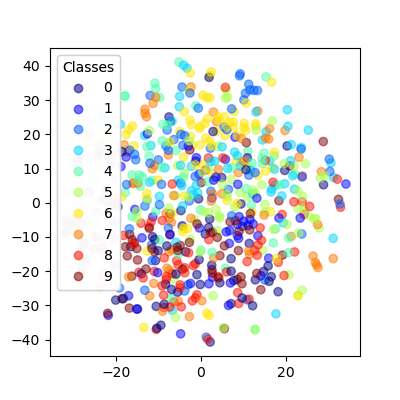

In [11]:
visualize_embeddings_in_test_split()

In [12]:
# Similar to Radford [CLIP]

class InfoNCELoss(_Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = "mean") -> None:
        super().__init__(size_average, reduce, reduction)
        self.cross_entropy_loss = CrossEntropyLoss()

    def forward(self, input_a: torch.Tensor, input_b: torch.Tensor, tau: torch.Tensor):
        tau = torch.clamp(tau, min=0.01, max=100)
        modality1_norm = F.normalize(input_a)
        modality2_norm = F.normalize(input_b)
        logits = torch.matmul(modality1_norm, modality2_norm.T) * torch.exp(tau)
        labels = torch.arange(logits.size(0)).to(logits.device)
        loss1 = self.cross_entropy_loss(logits, labels)
        loss2 = self.cross_entropy_loss(logits.T, labels)
        return (loss1 + loss2) / 2

contrastive_loss = InfoNCELoss()

In [13]:
def run_1epoch():
    for img, target in torch.utils.data.DataLoader(train_data, batch_size=512, collate_fn=custom_collate_fn, num_workers=2, pin_memory=True, shuffle=True):
        with torch.no_grad():
            img_tensor: torch.Tensor = (
                img
                .to(torch.float32)
                .to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            )
            target_tensor: torch.Tensor = (
                target
                .to(torch.float32)
                .to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            )
            embedding = model(img_tensor)
        image_embedding = compressor(embedding)
        label_embedding = label_encoder(target_tensor)
        loss = contrastive_loss(image_embedding, label_embedding, hparam_tau)

        opt.zero_grad()
        loss.backward()
        opt.step()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


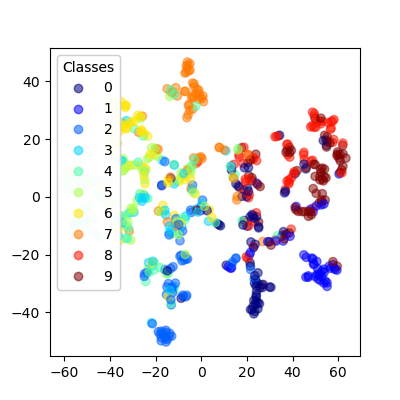

In [14]:
run_1epoch()

visualize_embeddings_in_test_split()